# Figure S7

In [11]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import cv2
import pandas as pd
import numpy as np
sys.path.append("../")

from scipy.stats import pearsonr, spearmanr
from scipy.sparse import issparse
from sklearn.metrics.pairwise import cosine_similarity
from Dataloader.Dataset import *

gc.collect()

abs_path = "../Implementation"
model_weight_path = "../Model_Weights"
res_path = "../Results"
data_path = "../Dataset"

gene_list = "func"
dataset_name = "BC_visium"
target_gene_list = list(np.load(f'{data_path}/Gene_list/Gene_list_{gene_list}_{dataset_name}.npy', allow_pickle=True))


In [25]:
def get_R(data1, data2, dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[1]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

# For the graph construction
def make_res(names, PAG, HSG, SLG):
    for name in names:
        print(f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}, {name}")
        pred = sc.read_h5ad(f"{res_path}/New_GraphBuild/pred_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        gt = sc.read_h5ad(f"{res_path}/New_GraphBuild/gt_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        data1, data2 = gt, pred
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        spc, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        PCC_BC_Visium = {
                        "Gene": target_gene_list,
                        "Pearson correlation": pcc,
                        "PCC_PValue": PCC_PValue,
                        "Spearmanr correlation": spc,
                        "SPC_PValue": SPC_PValue,
                        "SSIM_Score": ssim_score,
                        "Cosine_Score": cosine_score,
                        # "Moran'I_Score": MI,
                        "Slides": [name]*len(pcc),
                        "Method": f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}"
                        }
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)    
        PCC_BC_Visium.to_csv(f"{res_path}/New_GraphBuild/{name}_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{gene_list}.csv")                        

# For the message passing
def make_res_messagepass(model_name, names, PAG, HSG, SLG):
    for name in names:
        print(f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}, {name}")
        pred = sc.read_h5ad(f"{res_path}/New_GraphBuild/pred_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        gt = sc.read_h5ad(f"{res_path}/New_GraphBuild/gt_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{name}_{gene_list}.h5ad")
        data1, data2 = gt, pred
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        spc, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        PCC_BC_Visium = {
                        "Gene": target_gene_list,
                        "Pearson correlation": pcc,
                        "PCC_PValue": PCC_PValue,
                        "Spearmanr correlation": spc,
                        "SPC_PValue": SPC_PValue,
                        "SSIM_Score": ssim_score,
                        "Cosine_Score": cosine_score,
                        # "Moran'I_Score": MI,
                        "MessagePass": [model_name]*len(pcc),
                        "Slides": [name]*len(pcc),
                        "Method": f"SLG:{SLG}, PAG:{PAG}, HSG:{HSG}"
                        }
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)    
        PCC_BC_Visium.to_csv(f"{res_path}/New_GraphBuild/MessagePass/{name}_{model_name}_SLG_{str(SLG)}PAG{str(PAG)}_HSG{str(HSG)}_{gene_list}.csv")                        


def visualize_res(df, view, kind="Method", save_path="tmp.pdf"):
    # Collect garbage to free up memory
    gc.collect()

    if view == "local":
        # Set the font size for better readability
        plt.rcParams.update({'font.size': 16})

        # Create subplots with a 2x2 grid
        fig, axs = plt.subplots(2, 2, figsize=(18, 9))

        # List of columns and corresponding y-axis labels for plotting
        columns_to_plot = [
            ('Pearson correlation', 'Pearson correlation', False),
            ('Spearmanr correlation', 'Spearmanr correlation', False),
            ('Cosine_Score', 'Cosine Score', False),
            ('SSIM_Score', 'SSIM Score', False),
        ]

        # Loop through the columns and plot on the corresponding subplot
        for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
            row_index = i // 2
            col_index = i % 2
            sns.boxplot(x='Slides', y=column, hue=kind, data=df, ax=axs[row_index, col_index], showfliers=False, orient="v")
            
            # Rotate x-axis labels with 10 degrees
            axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
            
            # Remove legend for all subplots except the first one
            if not add_legend:
                axs[row_index, col_index].get_legend().remove()

            axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
            
            # Set y-axis label
            axs[row_index, col_index].set_ylabel(ylabel)

        # Adjust layout to prevent overlapping
        plt.tight_layout()

        # Save the plots as a PDF file
        plt.savefig(save_path)

        # Show the plots
        plt.show()

        # Collect garbage to free up memory
        gc.collect()
    elif view == "global":
        plt.figure(figsize=(15, 6))
        ax = sns.boxplot(x=kind, y='Pearson correlation', hue=kind, data=df, showfliers=False)

        # Move the legend above the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=len(df[kind].unique()))


## Figure S7 a)

In [2]:
gene_list = np.load("../Dataset/Gene_list/Gene_list_func_BC_visium.npy")
dataset = WeightedGraph_Anndata(fold=0, gene_list=gene_list, num_subsets=50,
                    train=False, r=112, exp_norm='lognorm', SLG=True, HSG=True, PAG=True,
                    neighs=8, color_norm="raw", target=target, distance_mode="distance",)


Datasize:6
Loading whole slide imgs...


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


subset_size: 81
Loading imgs...
Loading spatial coordinates...
Loading gene expression
Loading imgs...


100%|██████████| 50/50 [00:01<00:00, 27.99it/s]


Loading histogical image similarity graph...
Calculating spatial distance matrices...
Loading pathology annotations...
Loading pathology annotation graph...


In [3]:
pag = dataset.PAG_dict["1142243F-0"].numpy()
hsg = dataset.HSG_dict["1142243F-0"].numpy()
slg = dataset.SLG_dict["1142243F-0"].numpy()


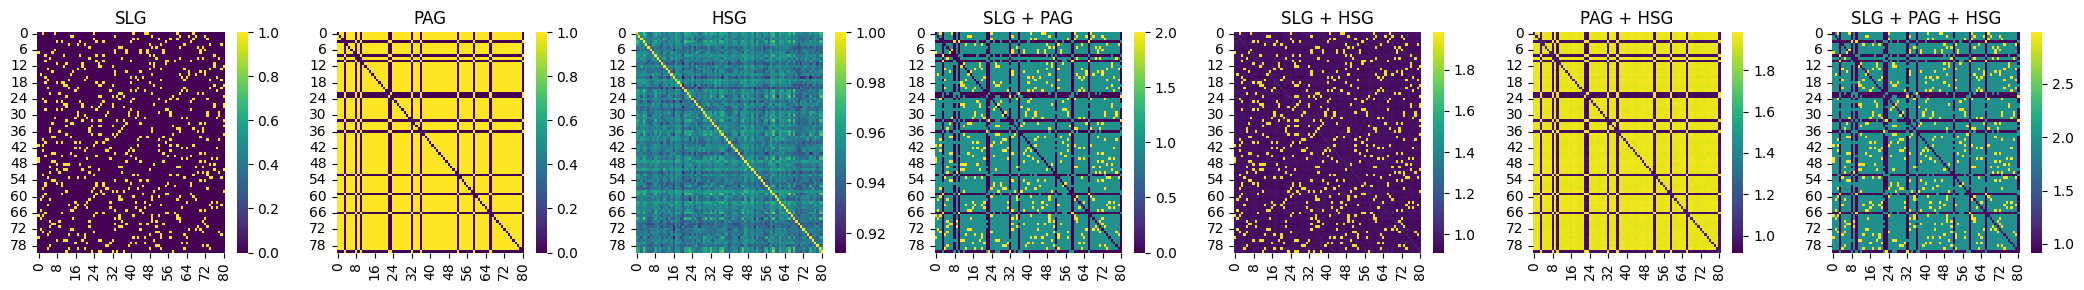

In [4]:
# Create a 1x7 subplot grid
fig, axes = plt.subplots(1, 7, figsize=(21, 3))

# Plot the heatmaps in the subplots
sns.heatmap(slg, ax=axes[0], cmap='viridis', cbar=True)
sns.heatmap(pag, ax=axes[1], cmap='viridis', cbar=True)
sns.heatmap(hsg, ax=axes[2], cmap='viridis', cbar=True)
sns.heatmap(slg + pag, ax=axes[3], cmap='viridis', cbar=True)
sns.heatmap(slg + hsg, ax=axes[4], cmap='viridis', cbar=True)
sns.heatmap(pag + hsg, ax=axes[5], cmap='viridis', cbar=True)
sns.heatmap(slg + pag + hsg, ax=axes[6], cmap='viridis', cbar=True)

# Set subplot titles
titles = ['SLG', 'PAG', 'HSG', 'SLG + PAG', 'SLG + HSG', 'PAG + HSG', 'SLG + PAG + HSG']
for ax, title in zip(axes, titles):
    ax.set_title(title)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## Figure S7 b)

In [ ]:
# Benchmarking graph construction results
names = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535', ] # 'FFPE', 'block1', 'block2'
model_name = "DeepPT_GNN"

# SLG
PAG = False
HSG = False
SLG = True
make_res(names, PAG, HSG, SLG)

# PAG
PAG = True
HSG = False
SLG = False
make_res(names, PAG, HSG, SLG)

# HSG
PAG = False
HSG = True
SLG = False
make_res(names, PAG, HSG, SLG)

# SLG + PAG
PAG = True
HSG = False
SLG = True
make_res(names, PAG, HSG, SLG)

# SLG + HSG
PAG = False
HSG = True
SLG = True
make_res(names, PAG, HSG, SLG)

# PAG + HSG
PAG = False
HSG = True
SLG = True
make_res(names, PAG, HSG, SLG)

# PAG + HSG + SLG
PAG = True
HSG = True
SLG = True
make_res(names, PAG, HSG, SLG)


In [13]:
graph_build = pd.concat([pd.read_csv(i) for i in glob.glob(f"{res_path}/New_GraphBuild/*csv")])

graph_build.replace("SLG:True, PAG:False, HSG:False", "SLG", inplace=True)
graph_build.replace("SLG:False, PAG:True, HSG:False", "PAG", inplace=True)
graph_build.replace("SLG:False, PAG:False, HSG:True", "HSG", inplace=True)
graph_build.replace("SLG:True, PAG:True, HSG:False", "SLG + PAG", inplace=True)
graph_build.replace("SLG:True, PAG:False, HSG:True", "SLG + HSG", inplace=True)
graph_build.replace("SLG:False, PAG:True, HSG:True", "HSG + PAG", inplace=True)
graph_build.replace("SLG:True, PAG:True, HSG:True", "SLG + HSG + PAG", inplace=True)
graph_build.sort_values(by="Method", ascending=True, inplace=True)


In [18]:
graph_build

,Unnamed: 0,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Method
814,814,RAC1,0.008649,0.291070,0.011725,0.227837,0.006326,0.795204,1142243F,HSG
1080,1080,LGALS1,-0.003123,0.578739,0.000460,0.488321,0.036095,0.978368,1142243F,HSG
1081,1081,CCR7,0.007654,0.313155,0.008379,0.296991,0.002060,0.099619,1142243F,HSG
1082,1082,IRAK2,-0.002052,0.551944,-0.002375,0.560054,0.001887,0.092861,1142243F,HSG
1083,1083,SDHA,0.034283,0.014565,0.032787,0.018468,0.005692,0.546057,1142243F,HSG
...,...,...,...,...,...,...,...,...,...,...
1091,1091,SPIB,0.007910,0.349270,0.007478,0.357115,0.001597,0.113745,CID4290,SLG + PAG
1092,1092,FANCE,0.012752,0.266176,0.008753,0.334112,0.002758,0.174751,CID4290,SLG + PAG
1093,1093,CD1A,0.004229,0.417986,-0.001993,0.538867,0.000241,0.053075,CID4290,SLG + PAG
1083,1083,SDHA,0.042377,0.018953,0.025700,0.104092,0.022277,0.703428,CID4290,SLG + PAG


643

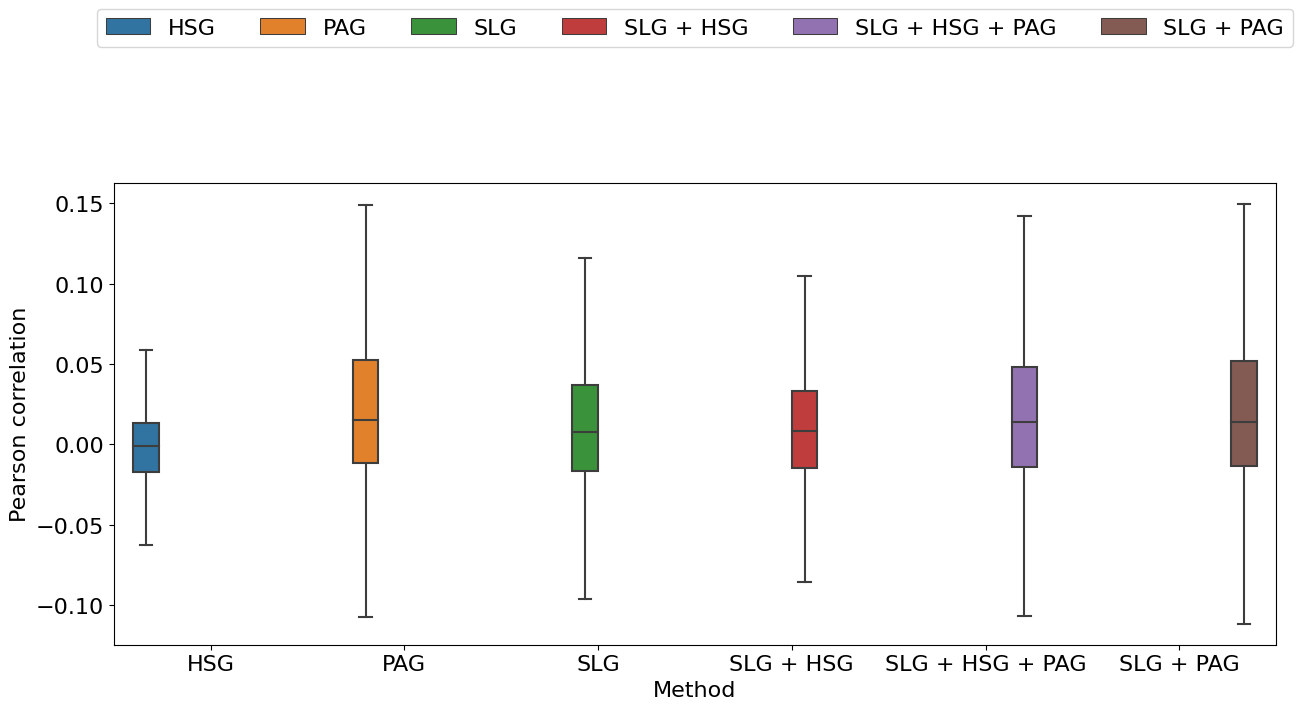

In [26]:
visualize_res(graph_build, "global", "Method")
gc.collect()

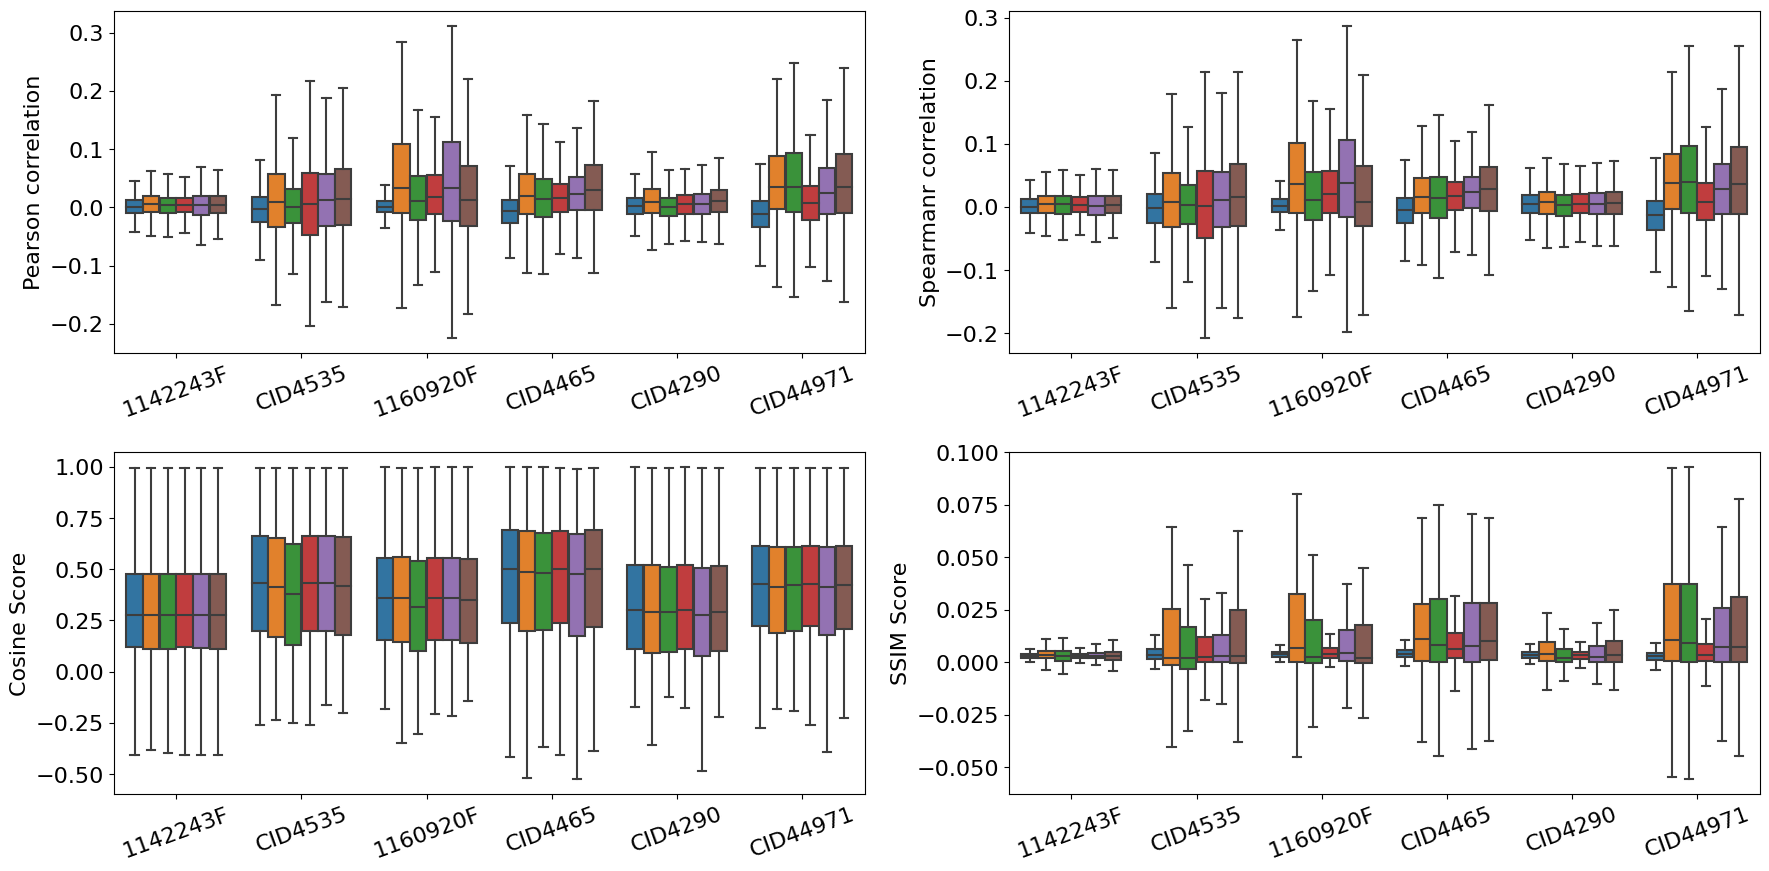

In [19]:
visualize_res(graph_build, "local", "Method")

## Figure S7 c)

In [ ]:
# Benchmarking message passing results
PAG = True
HSG = False
SLG = False
gnns = ["gcn", "gin", "gat"]
names = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535', ] # 'FFPE', 'block1', 'block2'
for gnn in gnns:
    model_name = f"DeepPT_{gnn}"
    make_res_messagepass(model_name, names, PAG, HSG, SLG)


In [14]:
messagepass = pd.concat([pd.read_csv(i) for i in glob.glob(f"{res_path}/New_GraphBuild/MessagePass/*csv")])

messagepass.replace("DeepPT_gat", "DeepPT_GAT", inplace=True)
messagepass.replace("DeepPT_gin", "DeepPT_GIN", inplace=True)
messagepass.replace("DeepPT_gcn", "DeepPT_GCN", inplace=True)
messagepass.sort_values(by="Method", ascending=True, inplace=True)


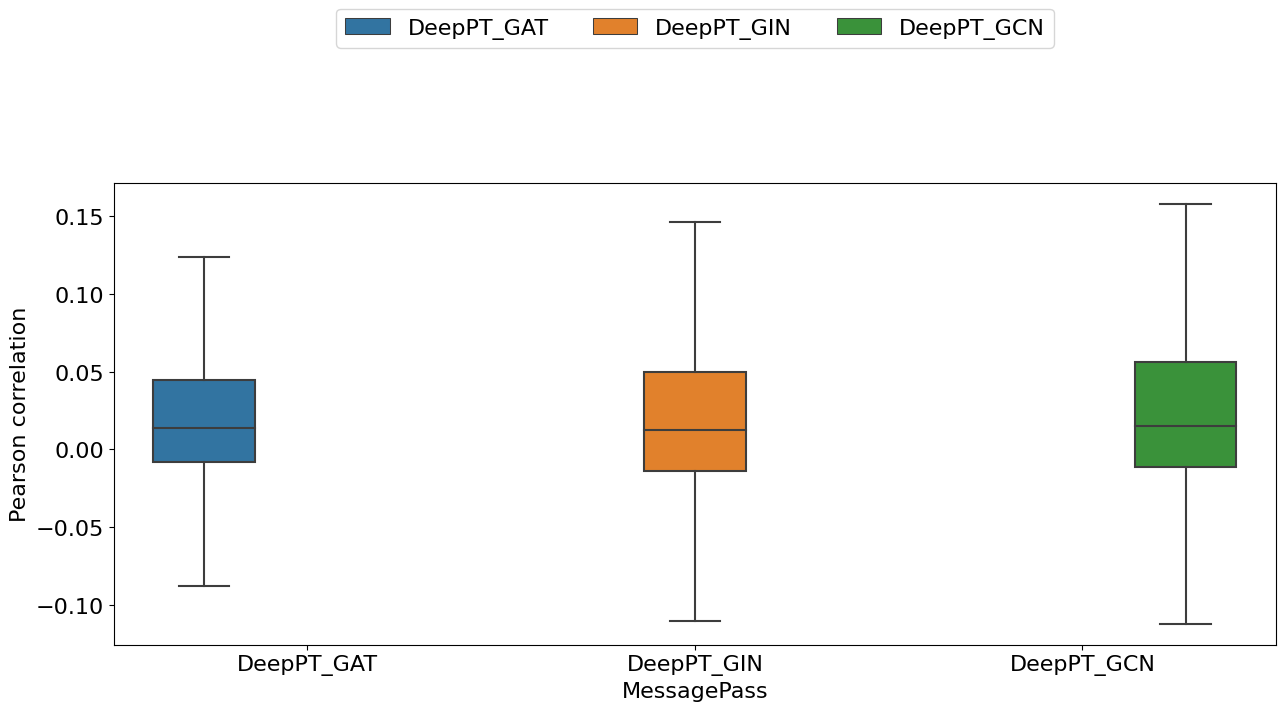

In [27]:
visualize_res(messagepass, "global", "MessagePass")


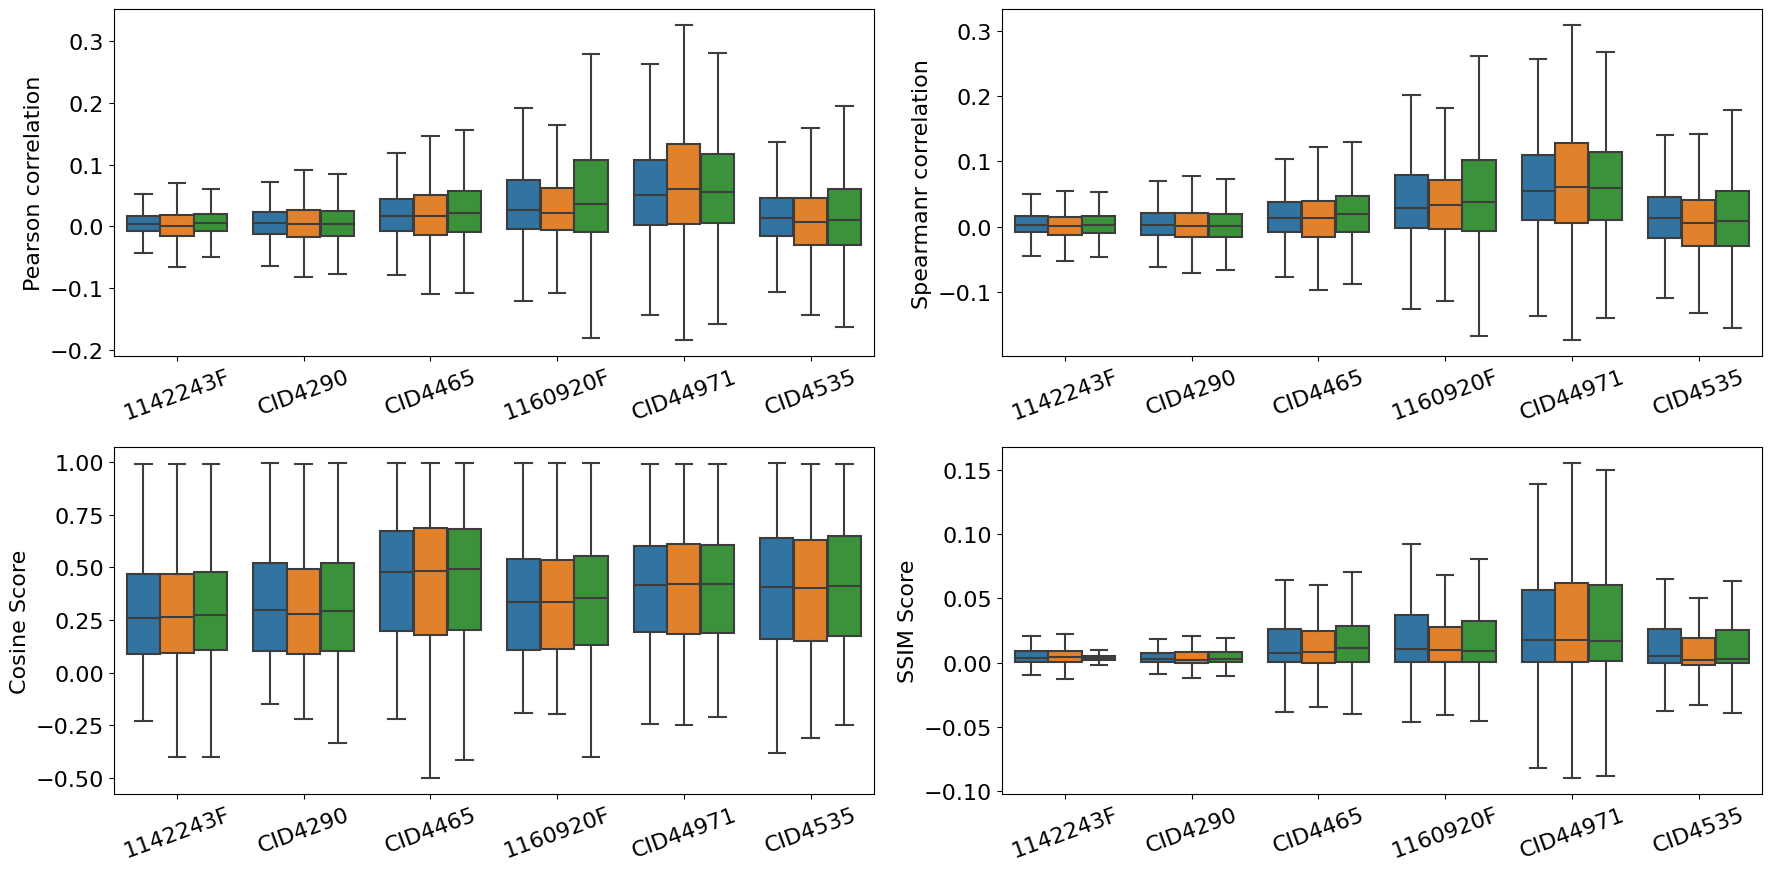

In [16]:
visualize_res(messagepass, "local", "MessagePass")
